## Data Exploration
Datasets: S&P500 (USA), Dow Jones (USA), Nasdaq (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), 
BSESN (India), DAX (Europe), SMI (Switzerland), MXX (Mexico), BVSP (Brazil)
1. Find the least correlated datasets
2. Distribution of prices, daily returns and drawdowns
3. Identification and definition of crashes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import seaborn as sns
from pylab import rcParams
from collections import defaultdict
from scipy.optimize import curve_fit
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv', \
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
plt_titles = ['S&P since 1950', 'N225 since 1965', 'SSE since 1996', 'HSI since 1987', \
              'BSESN since 1997', 'SMI since 1990', 'BVSP since 2002']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[5] = datasets[5].loc['1990-11-09':,:]  #<-- SMI has much missing data before 11/9/90

The histograms for daily return distributions show that the vast majority of returns lies between -0.05 and 0.05 for all datasets. The absolute values of extreme daily gains or losses are larger than 0.1. A visual comparison between the datasets shows that the SSE and BVSP have "fat tails" indicating a realtively high volatility with a large amount of high one day gains/large one day losses.

In [7]:
##### Drawdowns
dd_df = []
for ds in datasets:
    pmin_pmax = (ds['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(ds['price'][pmin.index]) - np.array(ds['price'][pmax.index])) \
        / np.array(ds['price'][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
         'duration': dur}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    dd_df.append(df_d)

# # Plot duration of drawdowns
# l_dict_dd = []
# for dd, t in zip(dd_df, plt_titles):
#     max_dd = max(abs(dd['drawdown']))
#     m = round(max_dd+0.01,2)
#     bins = np.linspace(-m, m, 800)
#     d = {}
#     for i in range(1, len(bins)+1):
#         d[i] = bins[i-1]
#     disc = np.digitize(x=dd['drawdown'], bins=bins)
#     d1 = defaultdict(int)
#     for i in disc:
#         d1[d[i]] += 1
#     l_dict_dd.append(d1)
#     plt.bar(x=dd['duration'].value_counts().index, height=dd['duration'].\
#         value_counts()/dd['duration'].shape[0], color='red', alpha=0.6)
#     plt.xticks(dd['duration'].value_counts().index)
#     plt.title(t + ' - Duration of drawdowns')
#     plt.xlabel('Duration (number of days)')
#     plt.grid()
#     plt.show()

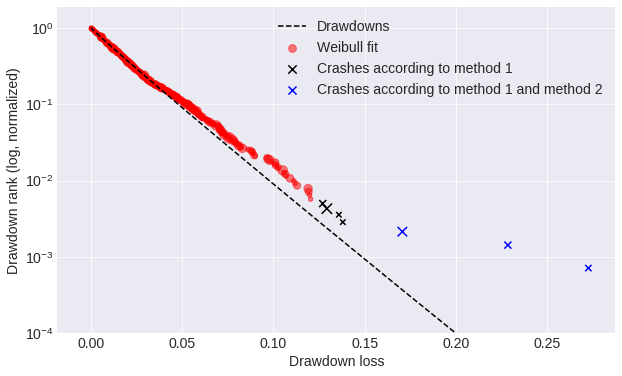

In [22]:
##### Fit Weibull exponential function to drawdowns by rank
def weibull(x, chi, z):
    return np.exp(-abs(x/chi)**z)

n_crashes1 = 3
n_crashes2 = 7
plt.style.use('seaborn-darkgrid')
rcParams['figure.figsize'] = 10, 6
rcParams.update({'font.size': 14})
x = dd_df[2]['drawdown']
y = dd_df[2]['rank'] / dd_df[2]['rank'].max()
init_vals = [0.9, 0.015]
best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
chi = best_vals[0]
z = best_vals[1]
plt.scatter(abs(x[n_crashes2:]), y[n_crashes2:], s=10*dd_df[2]['duration'][n_crashes2:], alpha=0.5, color='red')
plt.scatter(abs(x[n_crashes1:n_crashes2]), y[n_crashes1:n_crashes2], \
            s=10*dd_df[2]['duration'][n_crashes1:n_crashes2], color='black', marker='x')
plt.scatter(abs(x[:n_crashes1]), y[:n_crashes1], s=10*dd_df[2]['duration'][:n_crashes1], color='blue', marker='x')
y_fit = [weibull(abs(xi), chi, z) for xi in x]
plt.plot(abs(x), y_fit, color='black', ls='dashed')
plt.yscale('log')
plt.ylim(bottom=10**-4)
plt.legend(['Drawdowns', 'Weibull fit', 'Crashes according to method 1', \
            'Crashes according to method 1 and method 2'])
plt.xlabel('Drawdown loss')
plt.ylabel('Drawdown rank (log, normalized)')
#plt.grid()
plt.show()

The Weibull exponential model: y ~ exp(-abs(x/chi)^z) has been used by Johansen and Sornette (2001) to fit the distributions of drawdowns by rank. As we weill discuss below, large deviations from the Weibull distribution are considered to be crashes.

### 3. Identify Crashes
- First methodology: crashes as the 99.5% empirical quantile of the drawdowns (as suggested by Jacobsson, E., Stockholm University, in 'How to predict crashes in financial markets with the Log-Periodic Power Law', 2009).
- Second methodology: Crashes as outliers of the fitted Weibull exponential model(as suggested by Johansen, A. and Sornette, D. in 'Large Stock Market Price Drawdowns Are Outliers', 2001). This methodology requires manual identification of crashes based on the Weibull plots.

#### 3.1 Crashes according to Jaccobsen

#### 2.2 Crashes according to Johansen and Sornette